In [316]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport chol 
%aimport simulation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [317]:
import os.path
from datetime import datetime
import numpy as np
from scipy import linalg
from pylab import *
from sklearn.decomposition.factor_analysis import FactorAnalysis

from chol import *
import simulation

# No spike regression

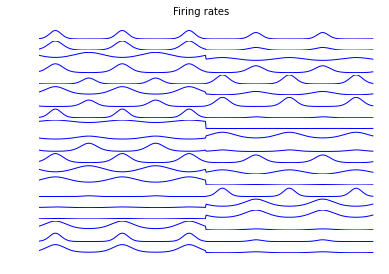

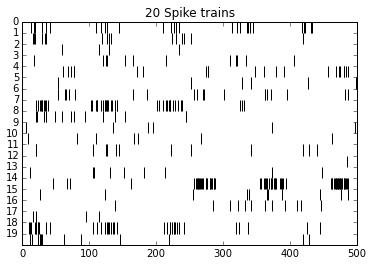

In [318]:
np.random.seed(0)

T = 500
w = 1e-4
std = 1
p = 0
L = 2
N = 20

high = np.log(25 / T)
low = np.log(5 / T)

# simulate latent processes
# x, ticks = simulation.latents(L, T, std, w)
x = np.empty((T, L), dtype=float)
x[:T // 2, 0] = high
x[T // 2:, 0] = low
x[:, 1] = 2 * np.sin(np.linspace(0, 2 * np.pi * 5, T))
for l in range(L):
    x[:, l] -= np.mean(x[:, l])

# simulate spike trains
a = 2 * np.random.rand(L, N) - 1
for l in range(L):
    a[l, :] /= linalg.norm(a[l, :]) / np.sqrt(N)

b = np.empty((1 + p*N, N))
b[0, :] = low

y, _, rate = simulation.spikes(x, a, b, intercept=True)
figure()
_, ax = subplots(N, sharex=True)
for n in range(N):
    ax[n].plot(rate[:, n])
    ax[n].axis('off')
suptitle('Firing rates')

figure()
ylim(0, N)
for n in range(N):
    vlines(np.arange(T)[y[:, n] > 0], n, n + 1, color='black')
title('{} Spike trains'.format(N))
yticks(range(N))
gca().invert_yaxis()

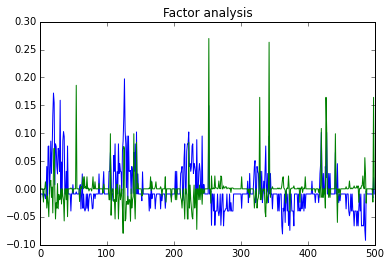

In [319]:
fa = FactorAnalysis(n_components=L)
m0 = fa.fit_transform(y)
a0 = fa.components_
# a0 = np.random.randn(L, N)
m0 *= np.linalg.norm(a0) / np.sqrt(N)
a0 /= np.linalg.norm(a0) / np.sqrt(N)

mu = np.zeros_like(x)

figure()
plot(m0)
title('Factor analysis')

In [326]:
var = np.empty(L, dtype=float)
var[0] = 2
var[1] = 2
w = np.empty(L, dtype=float)
w[0] = 1e-3
w[1] = 1e-3

control = {'max iteration': 50,
           'fixed-point iteration': 10,
           'tol': 1e-5,
           'verbose': True}

lbound, m1, a1, b1, new_var, new_scale, a0, b0, elapsed, converged = train(y, 0, var, w, b0=None, m0=m0, normofalpha=np.sqrt(N), hyper=True, kchol=10, control=control)

[ 1.          0.001998    0.00796809  0.01783897  0.03149342  0.04877058
  0.0694691   0.0933511   0.12014662  0.1495588   0.18126925  0.21494382
  0.25023841  0.28680471  0.32429589  0.36237185  0.40070421  0.43898072
  0.47690909  0.51422028  0.55067104  0.58604583  0.62015804  0.65285058
  0.68399587  0.7134952   0.7412777   0.76729879  0.79153831  0.8139984
  0.83470111  0.85368596  0.87100737  0.88673216  0.90093707  0.91370641
  0.92512985  0.93530038  0.94431252  0.95226068  0.9592378   0.96533414
  0.97063642  0.97522698  0.97918331  0.98257763  0.98547669  0.98794168
  0.99002826  0.9917867   0.99326205  0.99449446  0.99551941  0.9963681
  0.99706779  0.99764214  0.99811155  0.99849355  0.99880308  0.9990528
  0.99925341  0.99941389  0.99954171  0.99964308  0.99972314  0.9997861
  0.9998354   0.99987385  0.9999037   0.99992678  0.99994455  0.99995817
  0.99996858  0.99997649  0.99998248  0.99998699  0.99999038  0.99999292
  0.99999481  0.99999621  0.99999724  0.999998    0.999

/Users/yuan/variational/chol.py:35: RuntimeWarning: overflow encountered in exp
  newAcol = np.exp(- omega * (x[pvec[i + 1:]] - x[pvec[i]]) ** 2)
/Users/yuan/variational/chol.py:34: RuntimeWarning: invalid value encountered in sqrt
  g[i, i] = np.sqrt(diagG[jast])
/Users/yuan/variational/chol.py:37: RuntimeWarning: invalid value encountered in subtract
  g[i + 1:, i] = (newAcol -


ValueError: array must not contain infs or NaNs

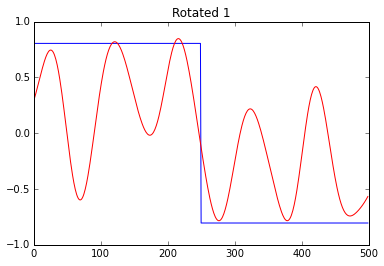

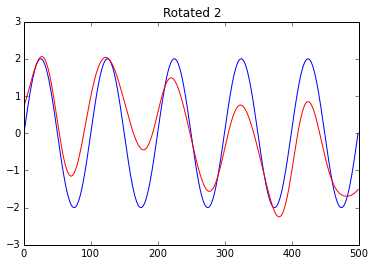

In [307]:
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

In [292]:
g = inchol(T, 0.0011, 10)

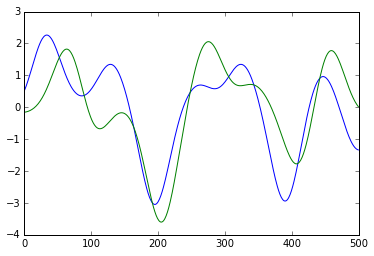

In [309]:
plot(m1)